In [1]:
using DynamicalSystems
using OrdinaryDiffEq
using DifferentialEquations
# using SciPy
using Statistics
using StaticArrays
using CairoMakie

In [2]:
function sigma(x)
    return 1.0 / ( 1.0 + exp( -10.0 * ( x  - ( - 0.25 ) ) ) )
end

function HR(u, p, t)
        
    a, b, c, d, s, xr, r,  I, vs, k1, k2, el_link  = p
    x1, y1, z1, x2, y2, z2 = u
    
    du1 = y1 + b * x1 ^ 2 - a * x1 ^3 - z1 + I - k1 * ( x1 - vs ) * sigma(x2) + el_link * ( x2 - x1 )
    du2 = c - d * x1 ^2 - y1
    du3 = r * ( s * ( x1 - xr ) - z1 )
    
    du4 = y2 + b * x2 ^ 2 - a * x2 ^3 - z2 + I - k2 * ( x2 - vs ) * sigma(x1) + el_link * ( x1 - x2 )
    du5 = c - d * x2 ^2 - y2
    du6 = r * ( s * ( x2 - xr ) - z2 )
    return SVector(du1, du2, du3,
                    du4, du5, du6)
end

HR (generic function with 1 method)

In [3]:
function peaks(x)
    peaks_ = Float64[]
    len_ = length(x)
    for i in range(2, len_ - 1, step = 1)
        if x[i-1] < x[i] > x[i+1]
            push!(peaks_, x[i])
        end
    end
    return peaks_
end

peaks (generic function with 1 method)

In [4]:
tspan = (0.0, 300000.0)

a = 1.0
b = 3.0
c = 1.0
d = 5.0
xr = -1.6
r = 0.01
s = 5.0
I = 4.0
xv = 2.0

k1= -0.17
k2 = k1
k = 0.0;

In [5]:
start_k1, end_k1, step_k1 = -0.5, 0.5, 0.01
start_k2, end_k2, step_k2 = -0.5, 0.5, 0.01

k1_array = range( start_k1, end_k1, step = step_k1 )
k2_array = range( start_k2, end_k2, step = step_k2 )

-0.5:0.01:0.5

In [6]:
spectrum_matrix = zeros( ( length(k1_array), length(k2_array), 6 ) )
EV_map = zeros( ( length(k1_array), length(k2_array) ) );

In [ ]:
for (k1_index, k1) in enumerate( k1_array )

    for (k2_index, k2) in enumerate( k2_array )
        
        if k1_index == k2_index
            
            k1 = round(k1, digits = 2)
            k2 = round(k2, digits = 2)
            
            println("diagonal inheritance");  flush(stdout)
            println( " index k1: ", k1_index, "; k1: ", k1 );  flush(stdout)
            println( " index k2: ", k2_index, "; k2: ", k2 );  flush(stdout)
            
            if k1_index == 1
                global diagonalcondition = SA[-1.5, 0.0, 0.0, -2.5, 0.0, 0.0]
            end
            println("initial condition:", diagonalcondition);  flush(stdout)
            
            p = SA[a, b, c, d, s, xr, r, I, xv, k1, k2, k]
            
            println("param:", p);  flush(stdout)
            ds_HR = ContinuousDynamicalSystem(HR, diagonalcondition, p )
            
            spectrum = lyapunovspectrum(ds_HR, tspan[2];
                                        diffeq = (alg = AutoVern9(Rodas5()),
                                                    abstol = 1e-11, reltol = 1e-11, maxiters = 10000000)
                                        )
            spectrum_matrix[k1_index, k2_index, :] = spectrum
            
            println("spectrum:", spectrum);  flush(stdout)
            
            prob = ODEProblem(HR, diagonalcondition, tspan, p)
            sol = solve(prob, AutoVern9(Rodas5()), abstol = 1e-11, reltol = 1e-11, maxiters = 10000000)
            
            if spectrum[1] > 0
                
                x_sum = sol[1,:] + sol[4,:]
                println("x_sum before truncate length: ", length(x_sum)); flush(stdout)
                x_sum = x_sum[floor(Int, length(x_sum) / 2):end ]
                println("x_sum after truncate length: ", length(x_sum)); flush(stdout)
                
                # index = signal.argrelmax( x_sum )[1]
                # spikes = [x_sum[x] for x in index]
                spikes = peaks(x_sum)
                Hs = Statistics.mean(spikes) + 6 * Statistics.std(spikes)
                println("Hs: ", Hs);  flush(stdout)
                
                counts = spikes[spikes.>=Hs]
                println("counts: ", length(counts))
                EV_map[k1_index, k2_index]  = length(counts)
                
            end
            
            diagonalcondition = sol[length(sol.u)]
            println("EV:", EV_map[k1_index, k2_index]); flush(stdout)
            println("last value: ", diagonalcondition);  flush(stdout)
            println(" _______ ");  flush(stdout)
            println(" ");  flush(stdout)
            
            global rightcondition = diagonalcondition
            global upcondition = diagonalcondition
            
            k1_index_ = k1_index + 1
            k2_index_ = k2_index + 1
            
            if isdefined(Main, :IJulia)
                    Main.IJulia.stdio_bytes[] = 0
            end
            
            for k1_ in range((k1 + step_k1), end_k1, step = step_k1 )
                
                 
                k1_ = round(k1_, digits = 2)
                
                if k1_ > end_k1 || k2 > end_k2
                    println("condition on continue is done");  flush(stdout)
                    continue
                end
                
                println("Inheritance to the right");  flush(stdout)
                
                println( " index k1: ", k1_index_, "; k1: ", k1_ );  flush(stdout)
                println( " index k2: ", k2_index, "; k2: ", k2 );  flush(stdout)
                
                println("initial condition:", rightcondition);  flush(stdout)
                
                
                p = SA[a, b, c, d, s, xr, r, I, xv, k1_, k2, k]

                println("param:", p); flush(stdout)
                ds_HR = ContinuousDynamicalSystem(HR, rightcondition, p )
            
                spectrum = lyapunovspectrum(ds_HR, tspan[2];
                                            diffeq = (alg = AutoVern9(Rodas5()),
                                                        abstol = 1e-11, reltol = 1e-11, maxiters = 10000000))
                spectrum_matrix[k1_index_, k2_index, :] = spectrum
                
                println("spectrum:", spectrum);  flush(stdout)
            
                prob = ODEProblem(HR, rightcondition, tspan, p)
                sol = solve(prob, AutoVern9(Rodas5()), abstol = 1e-11, reltol = 1e-11, maxiters = 10000000)
                
                if spectrum[1] > 0
                    
                    x_sum = sol[1,:] + sol[4,:]
                    println("x_sum before truncate length: ", length(x_sum)); flush(stdout)
                    x_sum = x_sum[floor(Int, length(x_sum) / 2):end ]
                    println("x_sum after truncate length: ", length(x_sum)); flush(stdout)

                    # index = signal.argrelmax( x_sum )[1]
                    # spikes = [x_sum[x] for x in index]
                    spikes = peaks(x_sum)
                    Hs = Statistics.mean(spikes) + 6 * Statistics.std(spikes)
                    println("Hs: ", Hs);  flush(stdout)
                
                    counts = spikes[spikes.>=Hs]
                    println("counts: ", length(counts));  flush(stdout)
                    EV_map[k1_index_, k2_index]  = length(counts)
                end
            
                
                rightcondition = sol[length(sol.u)]
                
                println("EV:", EV_map[k1_index_, k2_index]); flush(stdout)
                println("last value: ",  sol[length(sol.u)]);  flush(stdout)
                
                
                k1_index_+=1
                println(">>>>>>>>>");  flush(stdout)
                print("  ");  flush(stdout)
                
                if isdefined(Main, :IJulia)
                    Main.IJulia.stdio_bytes[] = 0
                end
            end
            
            for k2_ in range((k2 + step_k2), end_k2, step = step_k2 )
                
                k2_ = round(k2_, digits = 2)
                
                if k1 > end_k1 || k2_ > end_k2
                    println("condition on continue is done");  flush(stdout)
                    continue
                end
                
                println("Inheritance upwards");  flush(stdout)
                
                println( " index k1: ", k1_index, "; k1: ", k1 );  flush(stdout)
                println( " index k2: ", k2_index_, "; k2: ", k2_ );  flush(stdout)
                
                println("initial condition:", upcondition);  flush(stdout)
                
                p = SA[a, b, c, d, s, xr, r, I, xv, k1, k2_, k]
                println("param:", p);  flush(stdout)
                ds_HR = ContinuousDynamicalSystem(HR, upcondition, p )
            
                spectrum = lyapunovspectrum(ds_HR, tspan[2];
                                diffeq = (alg = AutoVern9(Rodas5()),
                                            abstol = 1e-11, reltol = 1e-11, maxiters = 10000000))
                spectrum_matrix[k1_index, k2_index_ ,:] = spectrum
                
                println("spectrum:", spectrum);  flush(stdout)
            
                prob = ODEProblem(HR, upcondition, tspan, p)
                sol = solve(prob, AutoVern9(Rodas5()), abstol = 1e-11, reltol = 1e-11, maxiters = 10000000)
                
                if spectrum[1] > 0
                    
                    x_sum = sol[1,:] + sol[4,:]
                    println("x_sum before truncate length: ", length(x_sum)); flush(stdout)
                    x_sum = x_sum[floor(Int, length(x_sum) / 2):end ]
                    println("x_sum after truncate length: ", length(x_sum)); flush(stdout)
                
                    # index = signal.argrelmax( x_sum )[1]
                    # spikes = [x_sum[x] for x in index]
                    spikes = peaks(x_sum)
                    Hs = Statistics.mean(spikes) + 6 * Statistics.std(spikes)
                    println("Hs: ", Hs);  flush(stdout)
                
                    counts = spikes[spikes.>=Hs]
                    println("counts: ", length(counts));  flush(stdout)
                    EV_map[k1_index, k2_index_]  = length(counts)
                end
            
                upcondition = sol[length(sol.u)]
                
                println("lyap:", spectrum);  flush(stdout)
                println("EV:", EV_map[k1_index, k2_index_]); flush(stdout)
                println("last value: ", sol[length(sol.u)]);  flush(stdout)
                
                
                k2_index_+=1
                println("^^^^^^^^^^");  flush(stdout)
                print("  ");  flush(stdout)
                
                if isdefined(Main, :IJulia)
                    Main.IJulia.stdio_bytes[] = 0
                end

            end
        end
    end
    println("-------------");  flush(stdout)
    println(" ");  flush(stdout)
end

diagonal inheritance
 index k1: 1; k1: -0.5
 index k2: 1; k2: -0.5
initial condition:[-1.5, 0.0, 0.0, -2.5, 0.0, 0.0]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, -0.5, 0.0]
spectrum:[3.410095820793295e-5, -0.0049144659766724675, -0.019853086675152135, -0.020207932798553627, -5.7357574331490015, -14.170144166772255]
x_sum before truncate length: 5454274
x_sum after truncate length: 2727138
Hs: 2.0475852895722206
counts: 0
EV:0.0
last value: [-0.9423457440454616, -3.3890652419183254, 4.11695472567512, -1.3200870995665175, -8.430357895773918, 3.0408312516986133]
 _______ 
 
Inheritance to the right
 index k1: 2; k1: -0.49
 index k2: 1; k2: -0.5
initial condition:[-0.9423457440454616, -3.3890652419183254, 4.11695472567512, -1.3200870995665175, -8.430357895773918, 3.0408312516986133]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.49, -0.5, 0.0]
spectrum:[1.7397578126401382e-5, -0.004554283681420203, -0.01992721382998149, -0.022553979983916214, -5.702752731278474, -

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.38, -0.5, 0.0]
spectrum:[4.779305137700789e-6, -0.002308518565178194, -0.0023103524667783142, -0.06051791463666051, -5.870962306290817, -13.86859720126109]
x_sum before truncate length: 5302977
x_sum after truncate length: 2651490
Hs: 1.6766447355420668
counts: 0
EV:0.0
last value: [-1.2125245465885164, -6.244332868469403, 3.955532463921844, -0.9573783075833163, -4.240763094087698, 3.3112500426962685]
>>>>>>>>>
  Inheritance to the right
 index k1: 14; k1: -0.37
 index k2: 1; k2: -0.5
initial condition:[-1.2125245465885164, -6.244332868469403, 3.955532463921844, -0.9573783075833163, -4.240763094087698, 3.3112500426962685]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.37, -0.5, 0.0]
spectrum:[5.033196722151429e-6, -0.0025318752571158168, -0.0025467199290315264, -0.05725235513189003, -5.869227676148155, -13.860740120347232]
x_sum before truncate length: 5295848
x_sum after truncate length: 2647925
Hs: 1.6574127505086536


x_sum before truncate length: 5171999
x_sum after truncate length: 2586001
Hs: 1.5688078306461448
counts: 0
EV:0.0
last value: [-0.7948817218428677, -3.0340323137476943, 3.2383078246994623, -0.9083745869702744, -3.2057534196059776, 4.003189810553398]
>>>>>>>>>
  Inheritance to the right
 index k1: 26; k1: -0.25
 index k2: 1; k2: -0.5
initial condition:[-0.7948817218428677, -3.0340323137476943, 3.2383078246994623, -0.9083745869702744, -3.2057534196059776, 4.003189810553398]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.25, -0.5, 0.0]
spectrum:[5.169717004179016e-6, -0.005708378180331806, -0.005715053570160522, -0.0542916428631109, -5.765672279686722, -13.739749513698477]
x_sum before truncate length: 5163926
x_sum after truncate length: 2581964
Hs: 1.5853079742930674
counts: 0
EV:0.0
last value: [-1.4424313089183314, -9.690010845687414, 3.530838305628852, -0.9143885453559376, -3.4221844462225772, 3.820576196651309]
>>>>>>>>>
  Inheritance to the right
 index k1: 27; k1: -0.24

>>>>>>>>>
  Inheritance to the right
 index k1: 38; k1: -0.13
 index k2: 1; k2: -0.5
initial condition:[-0.6824892952301558, -1.965296803464319, 3.641830949231389, -0.9495508749505016, -3.501396789190394, 4.0423059074928105]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.13, -0.5, 0.0]
spectrum:[0.014078192208599538, 3.931230071820844e-6, -0.002891205647476633, -0.034350340836443546, -6.208860566768221, -12.43369402161839]
x_sum before truncate length: 4618664
x_sum after truncate length: 2309333
Hs: 2.4294257508450996
counts: 3
EV:3.0
last value: [-1.043999997772401, -4.3252526983194315, 4.0914231784227315, -0.7322875155762728, -2.74088751693001, 3.0958180868573377]
>>>>>>>>>
  Inheritance to the right
 index k1: 39; k1: -0.12
 index k2: 1; k2: -0.5
initial condition:[-1.043999997772401, -4.3252526983194315, 4.0914231784227315, -0.7322875155762728, -2.74088751693001, 3.0958180868573377]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.12, -0.5, 0.0]
spectrum:[0.01398

>>>>>>>>>
  Inheritance to the right
 index k1: 50; k1: -0.01
 index k2: 1; k2: -0.5
initial condition:[0.20330942268145363, 0.6456117850795337, 4.084466637928303, -1.1139492270983984, -4.432665608965717, 3.225938019150239]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.01, -0.5, 0.0]
spectrum:[1.210412457028694e-5, -0.003910230160761111, -0.009966285997688364, -0.023187585147339356, -5.836081741043121, -12.752563800520333]
x_sum before truncate length: 4508819
x_sum after truncate length: 2254411
Hs: 2.0945858612067356
counts: 0
EV:0.0
last value: [-1.168725811011867, -6.011456826644036, 3.665047917460726, -0.802035770265085, -2.4925666144419876, 3.913332693446543]
>>>>>>>>>
  Inheritance to the right
 index k1: 51; k1: 0.0
 index k2: 1; k2: -0.5
initial condition:[-1.168725811011867, -6.011456826644036, 3.665047917460726, -0.802035770265085, -2.4925666144419876, 3.913332693446543]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.0, -0.5, 0.0]
spectrum:[-3.59049661046

initial condition:[-1.0833515081609466, -5.054457132007861, 4.019982690756055, -0.04958696513565077, -5.676416193916827, 3.513523922633557]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.11, -0.5, 0.0]
spectrum:[0.01661214877840282, 0.0013397581070651652, -4.664973788661391e-5, -0.019347908167965697, -6.616937441234906, -11.484800202662367]
x_sum before truncate length: 4264162
x_sum after truncate length: 2132082
Hs: 3.15725861298378
counts: 9
EV:9.0
last value: [0.15750596589123714, 0.7014870209387938, 4.214966450904756, -1.1353585552531535, -3.9879973769970842, 3.962925405978537]
>>>>>>>>>
  Inheritance to the right
 index k1: 63; k1: 0.12
 index k2: 1; k2: -0.5
initial condition:[0.15750596589123714, 0.7014870209387938, 4.214966450904756, -1.1353585552531535, -3.9879973769970842, 3.962925405978537]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.12, -0.5, 0.0]
spectrum:[0.019061158151443134, 0.001601878589701288, -4.079860457359518e-5, -0.011964418467372525, -6.668

 index k1: 74; k1: 0.23
 index k2: 1; k2: -0.5
initial condition:[-0.7472495714367599, -2.2699243990962286, 3.9528765184664088, -0.7748235763879783, -4.680674299674685, 3.5512897237262773]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.23, -0.5, 0.0]
spectrum:[0.020314251656784497, 0.0009604700176719472, -0.0001208192837765481, -0.014085497593349395, -6.678339907100921, -11.510763714583941]
x_sum before truncate length: 4394722
x_sum after truncate length: 2197362
Hs: 3.9606458156662
counts: 0
EV:0.0
last value: [-1.0710556078116769, -4.6074166841499, 4.1191618939973, -0.5010892324308669, -1.2316628422823486, 3.424876014489093]
>>>>>>>>>
  Inheritance to the right
 index k1: 75; k1: 0.24
 index k2: 1; k2: -0.5
initial condition:[-1.0710556078116769, -4.6074166841499, 4.1191618939973, -0.5010892324308669, -1.2316628422823486, 3.424876014489093]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.24, -0.5, 0.0]
spectrum:[0.02090452232533592, 0.0009919309490912622, -0.0001572

 index k1: 86; k1: 0.35
 index k2: 1; k2: -0.5
initial condition:[-1.0403232020967206, -4.672360914283708, 3.673260374921193, -0.9541365506001529, -3.594453176885577, 3.9989979502154354]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.35, -0.5, 0.0]
spectrum:[0.019431278847225803, 0.0024207028969850906, -1.2322226380001867e-5, -0.017133944251539347, -6.689218911678143, -11.569230925870874]
x_sum before truncate length: 4474245
x_sum after truncate length: 2237124
Hs: 4.255078176206535
counts: 0
EV:0.0
last value: [-0.9643623839032083, -3.5831935829192836, 4.1336772443302765, -0.612998120804352, -1.6885633291271458, 3.5153814859743986]
>>>>>>>>>
  Inheritance to the right
 index k1: 87; k1: 0.36
 index k2: 1; k2: -0.5
initial condition:[-0.9643623839032083, -3.5831935829192836, 4.1336772443302765, -0.612998120804352, -1.6885633291271458, 3.5153814859743986]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.36, -0.5, 0.0]
spectrum:[0.020228485295536124, 0.002264708428602562

 index k1: 98; k1: 0.47
 index k2: 1; k2: -0.5
initial condition:[-1.0405894153733697, -4.537889311754375, 3.876557953777072, -0.5605733616171976, -1.28427571731834, 3.686418073388616]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.47, -0.5, 0.0]
spectrum:[0.027310378120195888, 0.0038180183181429897, -1.1819951474596028e-5, -0.015095690392548272, -6.7389133107861685, -11.54521006177576]
x_sum before truncate length: 4491614
x_sum after truncate length: 2245808
Hs: 4.680161942100531
counts: 0
EV:0.0
last value: [0.025608381983104993, 0.24371943341109098, 4.053265592497119, -1.1548904893665695, -4.62865860028613, 3.6968267796130636]
>>>>>>>>>
  Inheritance to the right
 index k1: 99; k1: 0.48
 index k2: 1; k2: -0.5
initial condition:[0.025608381983104993, 0.24371943341109098, 4.053265592497119, -1.1548904893665695, -4.62865860028613, 3.6968267796130636]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, 0.48, -0.5, 0.0]
spectrum:[0.02706773765242256, 0.004147643416511436, -3.

EV:0.0
last value: [0.09319746306317882, 0.4721365546760178, 3.8612861741865316, -1.4039075391445937, -8.082602651978931, 3.25969021661064]
^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 9; k2: -0.42
initial condition:[0.09319746306317882, 0.4721365546760178, 3.8612861741865316, -1.4039075391445937, -8.082602651978931, 3.25969021661064]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, -0.42, 0.0]
spectrum:[-1.0588288409216097e-6, -0.0013619094475018185, -0.0013766111133071523, -0.07401721242614852, -5.873500114625883, -13.895803732474361]
lyap:[-1.0588288409216097e-6, -0.0013619094475018185, -0.0013766111133071523, -0.07401721242614852, -5.873500114625883, -13.895803732474361]
EV:0.0
last value: [-1.5282759851027583, -9.71536397087013, 3.164420628126276, 0.15991534748921366, -4.749197879635856, 4.066610808312355]
^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 10; k2: -0.41
initial condition:[-1.5282759851027583, -9.71536397087013, 3.16

^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 19; k2: -0.32
initial condition:[-0.6043420586164342, -1.594968307452615, 3.5741281937227143, -1.404348066745791, -8.978815257271087, 3.6685004585070473]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, -0.32, 0.0]
spectrum:[1.1583044081388366e-5, -0.0037107946294579757, -0.0037185590299368748, -0.04874824156099168, -5.846728751812057, -13.813560194314956]
x_sum before truncate length: 5247010
x_sum after truncate length: 2623506
Hs: 1.5939039443633343
counts: 0
lyap:[1.1583044081388366e-5, -0.0037107946294579757, -0.0037185590299368748, -0.04874824156099168, -5.846728751812057, -13.813560194314956]
EV:0.0
last value: [-0.974375165985957, -4.305751464019701, 3.563070134193832, -1.4378832886175419, -9.35636729292847, 3.813667183570007]
^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 20; k2: -0.31
initial condition:[-0.974375165985957, -4.305751464019701, 3.563070134193832, -1.437883288617541

param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, -0.22, 0.0]
spectrum:[-6.597348427915045e-6, -0.0067704206960442085, -0.006794831695165355, -0.05075322435215632, -5.705662347590497, -13.727461698283594]
lyap:[-6.597348427915045e-6, -0.0067704206960442085, -0.006794831695165355, -0.05075322435215632, -5.705662347590497, -13.727461698283594]
EV:0.0
last value: [-1.284074584796247, -7.846064726177502, 3.164941853839365, -0.8431711473885729, -2.7586569315022658, 3.945708562089119]
^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 30; k2: -0.21
initial condition:[-1.284074584796247, -7.846064726177502, 3.164941853839365, -0.8431711473885729, -2.7586569315022658, 3.945708562089119]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, -0.21, 0.0]
spectrum:[1.0356951928945343e-5, -0.00730884488203114, -0.007315906613709363, -0.04297009449593468, -5.706771355128053, -13.709985676305903]
x_sum before truncate length: 5112133
x_sum after truncate length: 255606

x_sum before truncate length: 4600565
x_sum after truncate length: 2300284
Hs: 2.350866517722519
counts: 6
lyap:[0.013612703106501789, 3.6878393392864015e-6, -0.0033224035610771004, -0.032932862645346526, -6.205970297837589, -12.425067530233969]
EV:6.0
last value: [-1.3790694223052482, -8.498758342487656, 3.8256975632694807, -0.8914545417593484, -3.1287365771775013, 3.9436195433053878]
^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 40; k2: -0.11
initial condition:[-1.3790694223052482, -8.498758342487656, 3.8256975632694807, -0.8914545417593484, -3.1287365771775013, 3.9436195433053878]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, -0.11, 0.0]
spectrum:[0.01236050544432056, 6.992479787711622e-6, -0.004399600891206939, -0.03315926394614454, -6.18452995768887, -12.471811701661627]
x_sum before truncate length: 4630579
x_sum after truncate length: 2315291
Hs: 2.349286620246975
counts: 8
lyap:[0.01236050544432056, 6.992479787711622e-6, -0.004399600891206939,

x_sum before truncate length: 4590400
x_sum after truncate length: 2295201
Hs: 2.016803678456591
counts: 0
lyap:[1.4058141954220197e-5, -0.0022498232080248198, -0.005895575623318054, -0.029228658712075226, -5.848426182311181, -12.850718752742207]
EV:0.0
last value: [-0.9528160898657078, -3.4625628512319206, 4.118132708557405, -0.6906652748593627, -2.0639255480223366, 3.5831684099801904]
^^^^^^^^^^
  Inheritance upwards
 index k1: 1; k1: -0.5
 index k2: 50; k2: -0.01
initial condition:[-0.9528160898657078, -3.4625628512319206, 4.118132708557405, -0.6906652748593627, -2.0639255480223366, 3.5831684099801904]
param:[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.5, -0.01, 0.0]
spectrum:[6.474507708858845e-7, -0.00391487881709256, -0.009965148079169638, -0.023173848814948158, -5.8361171110599, -12.75268123546341]
x_sum before truncate length: 4508928
x_sum after truncate length: 2254465
Hs: 2.0946526224474438
counts: 0
lyap:[6.474507708858845e-7, -0.00391487881709256, -0.0099651480791696

In [ ]:
fig, ax, hm = heatmap(k1_array, k2_array, spectrum_matrix[:, :, 1], colormap = :seismic)
Colorbar(fig[:, end+1], hm)

fig

In [ ]:
fig, ax, hm = heatmap(k1_array, k2_array, EV_map, colormap = :seismic)
Colorbar(fig[:, end+1], hm)

fig

### old res

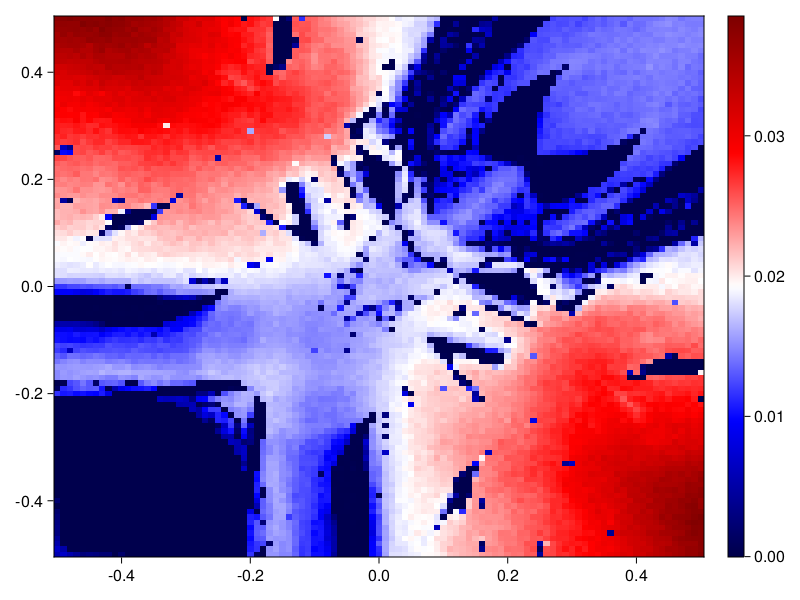

In [57]:
fig, ax, hm = heatmap(k1_array, k2_array, spectrum_matrix[:, :, 1], colormap = :seismic)
Colorbar(fig[:, end+1], hm)

fig

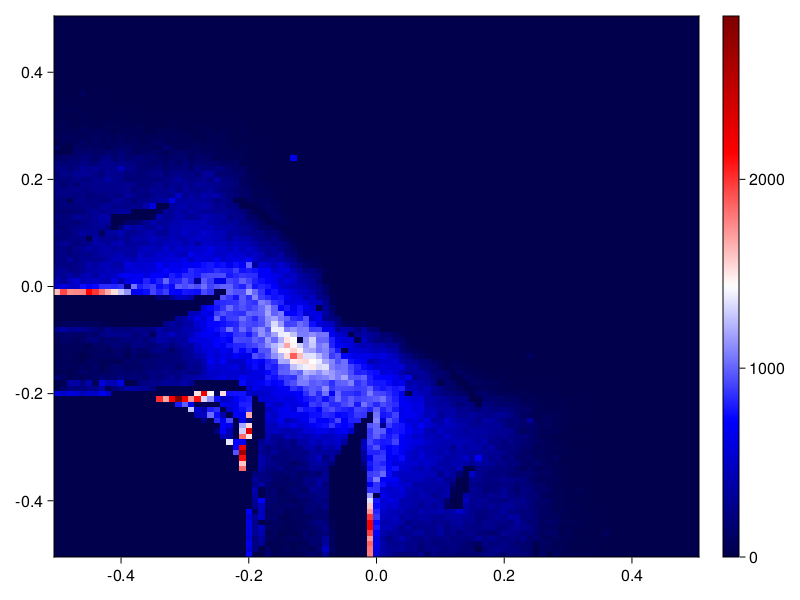

In [52]:
fig, ax, hm = heatmap(k1_array, k2_array, EV_map, colormap = :seismic)
Colorbar(fig[:, end+1], hm)

fig

In [55]:
using JLD
using NPZ

In [54]:
save("spectrum_matrix_k01.jld", "data", spectrum_matrix)
save("EV_map_k01.jld", "data", EV_map)

In [56]:
npzwrite("spectrum_matrix_k01.npy", spectrum_matrix)
npzwrite("EV_map_k01.npy", EV_map)

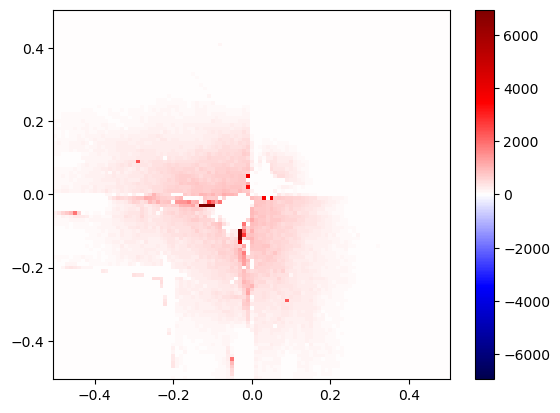

PyObject <matplotlib.colorbar.Colorbar object at 0x00000000497D32B0>

In [30]:
lyapmin,lyapmax =  -maximum( broadcast(abs, EV_map) ), maximum( broadcast(abs, EV_map) )

pcolormesh(k1_array, k2_array, EV_map, cmap ="seismic", vmin = lyapmin, vmax = lyapmax, shading="auto")

colorbar()

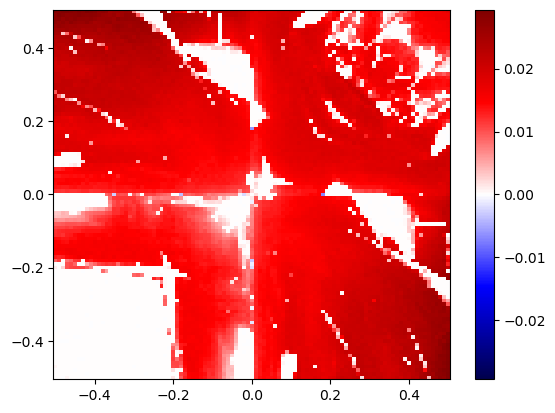

PyObject <matplotlib.colorbar.Colorbar object at 0x000000004988D190>

In [31]:
lyapmin,lyapmax = ( -maximum( broadcast(abs, lyap_matrix) ), maximum( broadcast(abs, lyap_matrix) ) )

pcolormesh(k1_array, k2_array, lyap_matrix, cmap ="seismic", vmin = lyapmin, vmax = lyapmax, shading="auto")

colorbar()

In [32]:
using NPZ
NPZ.npzwrite("Map_Lyap_HR_small_article.npy",lyap_matrix)
NPZ.npzwrite("Map_EV_HR_article.npy",EV_map)

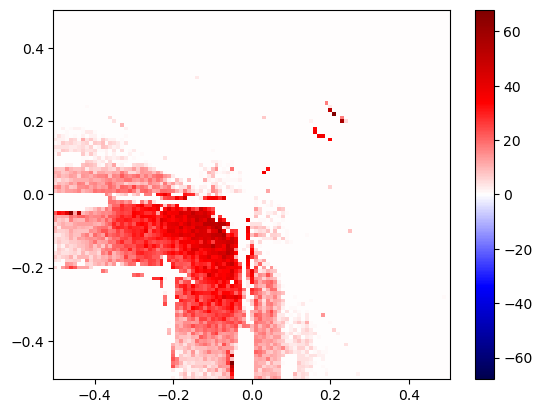

PyObject <matplotlib.colorbar.Colorbar object at 0x0000000009378790>

In [7]:
lyapmin,lyapmax = ( -maximum( broadcast(abs, EV_map) ), maximum( broadcast(abs, EV_map) ) )

pcolormesh(k1_array, k2_array, EV_map, cmap ="seismic", vmin = lyapmin, vmax = lyapmax, shading="auto")

colorbar()

In [10]:
lyap_matrix

101×101 Matrix{Float64}:
  8.19857e-6    6.47474e-5   5.14542e-5   …  0.0276682  0.0272808  0.0291445
  4.06075e-5    3.75252e-5   0.000253653     0.0272182  0.0277339  0.0292966
  3.13037e-5    0.000918656  5.90286e-5      0.0270186  0.0277955  0.029067
  0.000237857   3.48348e-5   2.37488e-5      0.027876   0.027632   0.0287336
  3.654e-5      2.7089e-5    1.00419e-5      0.028559   0.0286812  0.0300362
  9.94368e-6    2.23644e-6   8.28923e-6   …  0.0269209  0.0276201  0.0280668
  2.39406e-5    1.81937e-5   3.74486e-5      0.026856   0.0298292  0.0283967
 -1.85917e-6   -2.39113e-5   1.43275e-5      0.0272673  0.0279262  0.0277269
  1.61646e-5    3.30036e-5   1.4663e-6       0.0264745  0.0275779  0.0280929
 -1.3285e-6     2.29626e-5   6.41577e-6      0.0275636  0.0275413  0.0291799
 -9.06613e-6    9.54144e-6   2.41304e-6   …  0.0270102  0.0268263  0.0291496
  8.70916e-6    1.57952e-5   5.02821e-6      0.025589   0.0269834  0.025414
  3.66871e-5    3.24289e-5   1.65681e-5      0.025743

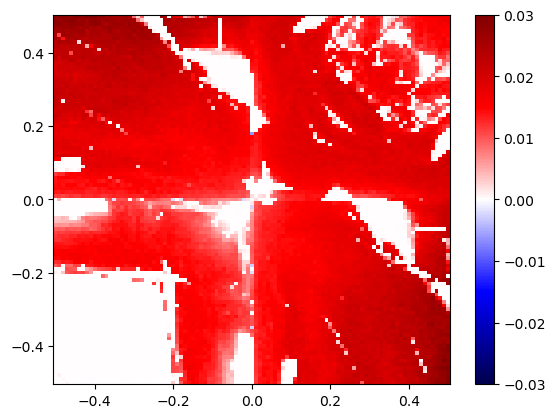

PyObject <matplotlib.colorbar.Colorbar object at 0x0000000008D51DC0>

In [11]:
lyapmin,lyapmax = ( -maximum( broadcast(abs, lyap_matrix) ), maximum( broadcast(abs, lyap_matrix) ) )

pcolormesh(k1_array, k2_array, lyap_matrix, cmap ="seismic", vmin = lyapmin, vmax = lyapmax, shading="auto")

colorbar()

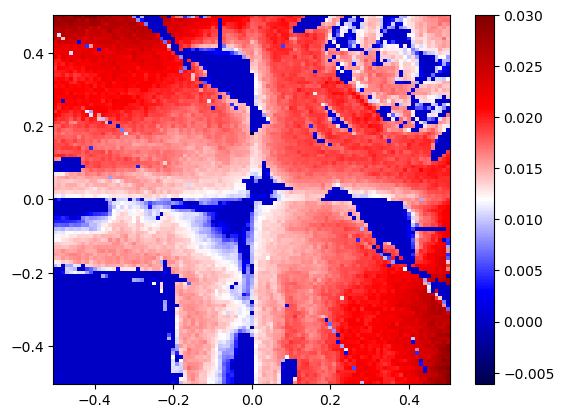

PyObject <matplotlib.colorbar.Colorbar object at 0x0000000008E93340>

In [16]:
lyapmin,lyapmax = minimum(lyap_matrix), maximum( lyap_matrix)

pcolormesh(k1_array, k2_array, lyap_matrix, cmap ="seismic", vmin = lyapmin, vmax = lyapmax, shading="auto")

colorbar()

In [12]:
using NPZ
NPZ.npzwrite("Map_Lyap_HR_small.npy",lyap_matrix)
NPZ.npzwrite("Map_EV_HR.npy",EV_map)